# Lab 9: Evaluation strategies in Machine Translation

Remember the main goal of machine translation task: estimate the model which predicts **high-quality** translation given the sentence written in the source language.

**What does high-quality mean?**

Ultimately we would want to hire top-notch translators from different domains such as literature translator, simulteneous speech translator and so on; then ask them to grade the translation given by the system. The problem is that using this way requires to hire translators *for every model* which we want to evaluate.

In order to reduce the cost of evaluation, we may use [multiple] reference translations given by professional translators and compare the output from our model with the corresponding reference translation.

How to do such comparison?

* Will exact match binary score work?

    Imagine the reference translation 'I have a kitten' and our model predicted 'I have a kitty'. Exact match would give us 0 while the translation is very decent as it provides the same information as the reference one.

* Will [Levenshtein distance](https://en.wikipedia.org/wiki/Levenshtein_distance) work? 

* Will n-gram overlap work? 

    Imagine splitting both reference and candidate into n-grams and compute how many n-grams are shared between those.

**There are infinitely many ways of computing some kind of score between two sequences. Which of those should we use?**

A good idea is to select a metric / strategy whose scores correlate with human judgement. 

In this lab we are going to explore several metrics and see how they differ between each other.

## BLEU: automatic corpus-level evaluation

https://aclanthology.org/P02-1040.pdf

BLEU is a de-facto standard choice for MT evaluation, but it has some limitations as well.

BLEU allows to use multi-reference evaluation set: every input sentence may have >=1 reference translation.

### Formulation

#### Modified ngram precision

The crux of the algorithm isa modified n-gram precision, which is based on [precision](https://en.wikipedia.org/wiki/Evaluation_measures_(information_retrieval)#Precision). 

Assuming unigrams for the moment, the modified unigram precision is described as:

One first counts the maximum number of times a word occurs in any single reference translation. Next, one clips the total count of each candidate word by its maximum reference count (in other words, one truncates each word’s count), adds these clipped counts up, and divides by the total (unclipped) number of candidate words.

**Example**:

Candidate: the the the mat the the the.

Ref 1: **The** cat is on **the** **mat**.

Ref 2: There is a cat on **the** **mat**.

Modified unigram precisions (defined for every candidate unigram): 

the: 2/6 = 0.333

mat: 1/1 = 1.

Modified unigram precision can be generalized to ngram:

In case of n=2, there are three unique bigrams in the candidate: the the, the mat, mat the. What is the modified precisions of bigram 'the the'?

#### Modified ngram precision on block of text

As we said before the BLEU is measured on the corpus-level. Having fixed number $N$ of pairs (candidate, references), the aggregated modified precision for ngram order $n$ is computed as: 

$$
p_{\text{n-order}} = \frac{\sum_{n=1}^N\sum_{\text{ngram} \in \text{cand}_n} \text{min}(C_{\text{cand}_n}(\text{ngram}), C_\text{maxref}(\text{ngram}))}{\sum_{n^\prime=1}^N\sum_{\text{ngram} \in \text{cand}_{n^\prime}} C_{\text{cand}_{n^\prime}}(\text{ngram})}
$$

#### Combining modified ngram precisions

![](https://drive.google.com/uc?export=view&id=1L_dl1m6Yeqpv8Ym7POgbC79qhfmdG-We)

Precisions decrease ~exponentially as we increase $n$. Geometric average of the modified precisions is used in order to incorporate the decay:

$$
m = \exp \sum_{{\text{n-order}}=1}^N w_\text{n-order} \log p_\text{n-order}
$$

#### Incorporating the sequence length

Modified ngram precision may assign unreasonably high precision to very short candidates! On the other hand, longer candidates receive lower score via the modified precision itself.

**Example:**

Candidate: of the

Reference: It is the guiding principle
which guarantees the military forces
always being under the command **of the**
Party.

$p_1 = \frac{2}{2}, p_2 = \frac{1}{1}$.

Multiplicative brevity penalty is introduced to address the issue of inflated score with shorter candidates. The idea is to penalize the score if the candidate is shorter than the closest reference translation in terms of length.

Consider such example:

Candidate 1 length: 2
Refeernce 1 length: 10

Candidate 2 length: 9
Refeernce 2 length: 11

Candidate 3 length: 10
Refeernce 3 length: 10

Computing penalties per sentence pair would make the penalty of the first one to be the outlier and deviate the total penalty. Instead, we compute penalty by summing together all candidate and closest reference lengths:

$$
BP = \exp (1 - \frac{r}{c}) \quad \text{if} \; c \leq r \; \text{else} \; 1
$$,
where $r,c$ are total effective lengths of all reference and candidate translations.

Finally, the BLEU is computed as:

$$
    \text{BLEU} = BP \cdot m 
$$

And again, **BLEU is a CORPUS-level metric**, as on sentence-level we can not say anything about correlation with human judgements.

Implications of BLEU design:

* More reference translations will increase the score.
* Even professional translators will not necessarily get 1. BLEU. 

## Estimation of BLEU using sacreBLEU package

It is very important to use exactly the same reference set when we compare BLEU scores from different teams/models etc. [SacreBLEU](https://github.com/mjpost/sacrebleu) keeps reference sets for many publicly available MT tasks and provides implementation of BLEU metric such that one only needs a **de-tokenized** list of candidates.

Why de-tokenized? It is a good idea to unify the tokenization scheme across different evaluations, so sacreBLEU will apply same tokenization to our candidates and to reference translations.

In [ ]:
# installing sacrebleu
! pip install sacrebleu

     |████████████████████████████████| 90 kB 3.7 MB/s 


In [ ]:
# download candidates from previous lab
! gdown --id 1GUCauFig_8iykf026IYbqn52HCf-e_EQ

Downloading...
From: https://drive.google.com/uc?id=1GUCauFig_8iykf026IYbqn52HCf-e_EQ
To: /content/eval_out_5.txt.test
100% 202k/202k [00:00<00:00, 74.0MB/s]


In [ ]:
# printing first 10 lines
! head -n 10 /content/eval_out_5.txt.test

the number of incoming recruits from <unk> is called .
the official representative of the people &apos;s militia of the self @-@ proclaimed <unk> people &apos;s republic ( <unk> ) <unk> macroko declared that in winter 2018 @-@
according to him , he said , <unk> plans &quot; at least to complete the divisions . &quot;
&quot; <unk> citizens &quot; reluctance to pass service in the ranks of <unk> <unk> , mass dismissal led to low @-@ cost units , &quot; said marokko ,
it also did not exclude that real figures intended to the army of <unk> ians can be increased if necessary .
in 2014 @-@ 2017 , <unk> began the so @-@ called anti @-@ terrorist operation ( <unk> ) , which was later replaced by the united forces ( <unk> )
it was assumed that this measure would strengthen the role of <unk> siloviki in resolving the situation .
at the end of <unk> 2018 , the situation in <unk> was exacerbated by the murder of the head of <unk> <unk> .
<unk> &apos;s authorities qualified what happened as a terro

In [ ]:
# we need to detokenize candidates and remove UNK tokens
lines_no_unk = []
with open('/content/eval_out_5.txt.test', 'r') as f:
    for l in f.readlines():
        l = l.replace('<unk>', '').strip()
        l = " ".join(l.split())
        lines_no_unk.append(l)

In [ ]:
lines_no_unk[:10]

['the number of incoming recruits from is called .',
 'the official representative of the people &apos;s militia of the self @-@ proclaimed people &apos;s republic ( ) macroko declared that in winter 2018 @-@',
 'according to him , he said , plans &quot; at least to complete the divisions . &quot;',
 '&quot; citizens &quot; reluctance to pass service in the ranks of , mass dismissal led to low @-@ cost units , &quot; said marokko ,',
 'it also did not exclude that real figures intended to the army of ians can be increased if necessary .',
 'in 2014 @-@ 2017 , began the so @-@ called anti @-@ terrorist operation ( ) , which was later replaced by the united forces ( )',
 'it was assumed that this measure would strengthen the role of siloviki in resolving the situation .',
 'at the end of 2018 , the situation in was exacerbated by the murder of the head of .',
 '&apos;s authorities qualified what happened as a terrorist attack .',
 'several people were detained during the criminal investi

In [ ]:
with open('clean_output_beam5.tok', 'w') as f:
    for l in lines_no_unk:
        f.write(f'{l}\n')

In [ ]:
%%shell

wget https://raw.githubusercontent.com/moses-smt/mosesdecoder/master/scripts/tokenizer/detokenizer.perl
chmod +x detokenizer.perl

--2021-10-26 21:24:31--  https://raw.githubusercontent.com/moses-smt/mosesdecoder/master/scripts/tokenizer/detokenizer.perl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12498 (12K) [text/plain]
Saving to: ‘detokenizer.perl’

detokenizer.perl    100%[===================>]  12.21K  --.-KB/s    in 0s      

2021-10-26 21:24:31 (35.3 MB/s) - ‘detokenizer.perl’ saved [12498/12498]



In [ ]:
! perl detokenizer.perl -l en -q < clean_output_beam5.tok > test.en.detok

In [ ]:
! head -n 10 test.en.detok

the number of incoming recruits from is called.
the official representative of the people's militia of the self-proclaimed people's republic () macroko declared that in winter 2018-
according to him, he said, plans "at least to complete the divisions."
"citizens" reluctance to pass service in the ranks of, mass dismissal led to low-cost units, "said marokko,
it also did not exclude that real figures intended to the army of ians can be increased if necessary.
in 2014-2017, began the so-called anti-terrorist operation (), which was later replaced by the united forces ()
it was assumed that this measure would strengthen the role of siloviki in resolving the situation.
at the end of 2018, the situation in was exacerbated by the murder of the head of.
's authorities qualified what happened as a terrorist attack.
several people were detained during the criminal investigation into the criminal case.


In [ ]:
! sacrebleu -i test.en.detok -t wmt19 -l ru-en

sacreBLEU: Downloading http://data.statmt.org/wmt19/translation-task/test.tgz to /root/.sacrebleu/wmt19/test.tgz
sacreBLEU: Checksum passed: 84de7162d158e28403103b01aeefc39a
sacreBLEU: Extracting /root/.sacrebleu/wmt19/test.tgz
sacreBLEU: Processing /root/.sacrebleu/wmt19/raw/sgm/newstest2019-ruen-src.ru.sgm to /root/.sacrebleu/wmt19/ru-en.ru
sacreBLEU: Processing /root/.sacrebleu/wmt19/raw/sgm/newstest2019-ruen-ref.en.sgm to /root/.sacrebleu/wmt19/ru-en.en
{
 "name": "BLEU",
 "score": 17.4,
 "signature": "nrefs:1|case:mixed|eff:no|tok:13a|smooth:exp|version:2.0.0",
 "verbose_score": "56.6/27.7/15.8/9.5 (BP = 0.788 ratio = 0.808 hyp_len = 34449 ref_len = 42642)",
 "nrefs": "1",
 "case": "mixed",
 "eff": "no",
 "tok": "13a",
 "smooth": "exp",
 "version": "2.0.0"
}


In [ ]:
# downloading different model's output
! gdown --id 1Y4JVr_1cjsup9ywO1cdlmGoGVULiPJKw

Downloading...
From: https://drive.google.com/uc?id=1Y4JVr_1cjsup9ywO1cdlmGoGVULiPJKw
To: /content/wmt19_ruen_tok.en
100% 223k/223k [00:00<00:00, 32.5MB/s]


In [ ]:
! perl detokenizer.perl -l en -q < wmt19_ruen_tok.en > test2.en.detok

In [ ]:
! sacrebleu -i test2.en.detok -t wmt19 -l ru-en

{
 "name": "BLEU",
 "score": 33.3,
 "signature": "nrefs:1|case:mixed|eff:no|tok:13a|smooth:exp|version:2.0.0",
 "verbose_score": "67.6/41.5/28.3/20.2 (BP = 0.935 ratio = 0.937 hyp_len = 39973 ref_len = 42642)",
 "nrefs": "1",
 "case": "mixed",
 "eff": "no",
 "tok": "13a",
 "smooth": "exp",
 "version": "2.0.0"
}


## Using HuggingFace datasets-metrics

https://huggingface.co/metrics

This package aggregates different mertics under the python wrapper.

In [ ]:
! pip install datasets

     |████████████████████████████████| 290 kB 4.2 MB/s 
     |████████████████████████████████| 243 kB 39.8 MB/s 
     |████████████████████████████████| 125 kB 52.4 MB/s 
     |████████████████████████████████| 1.3 MB 40.3 MB/s 
     |████████████████████████████████| 56 kB 4.9 MB/s 
     |████████████████████████████████| 160 kB 46.9 MB/s 
     |████████████████████████████████| 271 kB 50.0 MB/s 


In [ ]:
from datasets import load_metric
bleu_metric = load_metric("sacrebleu")

Downloading:   0%|          | 0.00/2.37k [00:00<?, ?B/s]

In [ ]:
! sacrebleu -t wmt19 -l ru-en --echo ref > wmt19_ref.en

In [ ]:
predictions = []
with open('./test2.en.detok', 'r') as f:
    for l in f.readlines():
        predictions.append(l.strip())

refs = []
with open('./wmt19_ref.en', 'r') as f:
    for l in f.readlines():
        refs.append([l.strip()])

In [ ]:
bleu_metric.compute(predictions=predictions, references=refs)

{'bp': 0.935410255681956,
 'counts': [27037, 15741, 10181, 6860],
 'precisions': [67.63815575513472,
  41.45313775577384,
  28.301781891974535,
  20.19131714495953],
 'ref_len': 42642,
 'score': 33.28005431544169,
 'sys_len': 39973,
 'totals': [39973, 37973, 35973, 33975]}

## METEOR metric

https://www.cs.cmu.edu/~alavie/METEOR/pdf/Banerjee-Lavie-2005-METEOR.pdf

Motivation behind meteor metric was to improve the correlation with human judgements compared to BLEU.

*'It evaluates a  translation  by  computing  a  score  based  on  explicit  word-to-word  matches  between  the  translation and a reference translation.'*

High-level step-by-step view:

* Generate the alignment:
Repeat n stages
1. Get aligner at stage i
2. Estimate word-level alignment between two sequences using this aligner using only not-aligned positions yet.

    * Default ordering of aligner types: (exact match, stem match, synonym match).

    ![](https://upload.wikimedia.org/wikipedia/commons/2/27/METEOR-alignment-a.png)


* Precision $P$ is computed as number of aligned unigrams from candidate (number of edges above) divided by the total number of unigrams in the **candidate**.

* Recall $R$ is computed as number of aligned unigrams from candidate (number of edges above) divided by the total number of unigrams in the **reference**. 

* $F_\text{mean} = \frac{10PR}{9P+R}$

* Length penalty: In order to compute this penalty, unigrams are grouped into the fewest possible chunks, where a chunk is defined as a set of unigrams that are adjacent in the hypothesis and in the reference. The longer the adjacent mappings between the candidate and the reference, the fewer chunks there are. A translation that is identical to the reference will give just one chunk. The penalty p is computed as follows: $p = 0.5\Big(\frac{\text{num chunks}}{\text{num aligned unigrams}}\Big)^3$

* Meteor score: $M = F_\text{mean} (1-p)$


In [ ]:
!pip install -U nltk

     |████████████████████████████████| 1.5 MB 4.3 MB/s 
     |████████████████████████████████| 748 kB 44.5 MB/s 
  Attempting uninstall: regex
    Found existing installation: regex 2019.12.20
    Uninstalling regex-2019.12.20:
      Successfully uninstalled regex-2019.12.20
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


In [ ]:
meteor_metric = load_metric("meteor")

Downloading:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
meteor_metric

Metric(name: "meteor", features: {'predictions': Value(dtype='string', id='sequence'), 'references': Value(dtype='string', id='sequence')}, usage: """
Computes METEOR score of translated segments against one or more references.
Args:
    predictions: list of predictions to score. Each prediction
        should be a string with tokens separated by spaces.
    references: list of reference for each prediction. Each
        reference should be a string with tokens separated by spaces.
    alpha: Parameter for controlling relative weights of precision and recall. default: 0.9
    beta: Parameter for controlling shape of penalty as a function of fragmentation. default: 3
    gamma: Relative weight assigned to fragmentation penalty. default: 0.5
Returns:
    'meteor': meteor score.
Examples:

    >>> meteor = datasets.load_metric('meteor')
    >>> predictions = ["It is a guide to action which ensures that the military always obeys the commands of the party"]
    >>> references = ["It is a gu

In [ ]:
single_reference_list = [r[0] for r in refs]

meteor_metric.compute(predictions=predictions, references=single_reference_list)

{'meteor': 0.6064950859796556}

## Learned metric: BLEURT: BERT trained to match human judgement.

Simialrly to our lab about transfer learning with BERT, pre-trained models can be utilized as evaluators too.

The final model is the '**reference [sep] candidate**' scorer:

$$
\text{score} = Wv_\text{[CLS]} + b,\\
v_\text{[CLS]} = f_\text{BERT}(ref,cand)
$$


![](https://1.bp.blogspot.com/-RoK03xeSsJ4/XtFYBk7o0ZI/AAAAAAAAGCc/NhvgzVsZfRALLZMmz_XRvxAr9-tcsurGQCLcBGAsYHQ/s400/image4.png)


![](https://1.bp.blogspot.com/-AtLJNnE7Kwc/XtFXyqAPjrI/AAAAAAAAGCU/C-WHyQ-XRxUceITNwpY-TqgHJAfCrxIUwCLcBGAsYHQ/s640/image1.png)

In [ ]:
%%shell
git clone https://github.com/google-research/bleurt.git
cd bleurt
pip install .

Cloning into 'bleurt'...
remote: Enumerating objects: 116, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (56/56), done.


CalledProcessError: ignored

In [ ]:
%%shell
# Downloads the 12-layer distilled model, which is ~3.5X smaller.
wget https://storage.googleapis.com/bleurt-oss-21/BLEURT-20-D12.zip .
unzip BLEURT-20-D12.zip

--2021-10-23 19:48:49--  https://storage.googleapis.com/bleurt-oss-21/BLEURT-20-D12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.214.128, 108.177.111.128, 108.177.121.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.214.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 625304855 (596M) [application/octet-stream]
Saving to: ‘BLEURT-20-D12.zip’

BLEURT-20-D12.zip   100%[===================>] 596.34M   138MB/s    in 4.9s    

2021-10-23 19:48:54 (122 MB/s) - ‘BLEURT-20-D12.zip’ saved [625304855/625304855]

--2021-10-23 19:48:54--  http://./
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2021-10-23 19:48:54--
Total wall clock time: 5.2s
Downloaded: 1 files, 596M in 4.9s (122 MB/s)
Archive:  BLEURT-20-D12.zip
   creating: BLEURT-20-D12/
  inflating: BLEURT-20-D12/bert_config.json  
  inflating: BLEURT-20-D12/saved_model.pb  
   creating: 

In [ ]:
%%shell
# Runs the scoring.
cd
python -m bleurt.score_files \
  -candidate_file=/content/test2.en.detok \
  -reference_file=/content/wmt19_ref.en \
  -bleurt_batch_size=100 \
  -batch_same_length=True \
  -scores_file='/content/bleurt_scores.txt' \
  -bleurt_checkpoint="/content/BLEURT-20-D12"

2021-10-23 19:55:29.480307: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-23 19:55:29.491734: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-23 19:55:29.492815: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
INFO:tensorflow:Running BLEURT scoring.
I1023 19:55:29.493981 140108400121728 score_files.py:169] Running BLEURT scoring.
W1023 19:55:29.494490 140108400121728 score_files.py:120] Enabling same length batching. BEWARE: this is an experimental feature.
INFO:tensorflow:Reading checkpoint /content/BLEURT-20-D12.
I1023 19:55:29.494694 1401084

In [ ]:
bleurt_scores = []
with open('./bleurt_scores.txt', 'r') as f:
    for l in f.readlines():
        bleurt_scores.append(float(l.strip()))

Populating the interactive namespace from numpy and matplotlib


Text(0, 0.5, 'Count')

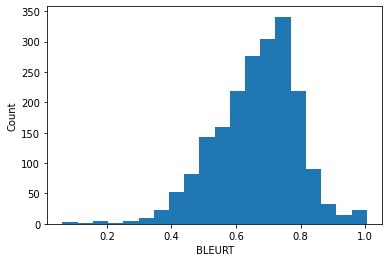

In [ ]:
%pylab inline
plt.hist(bleurt_scores,bins=20)
plt.xlabel('BLEURT')
plt.ylabel('Count')

## Holistic analysis of system outputs: compareMT

Some tools allow to see interesting statistics from your model's output such as length distributions, metrics and so on at the same time.

Today we will check compareMT: https://github.com/neulab/compare-mt

In [ ]:
%%shell
git clone https://github.com/neulab/compare-mt.git
# Requirements
cd compare-mt
pip install -r requirements.txt
# Install the package
python setup.py install

Cloning into 'compare-mt'...
remote: Enumerating objects: 1440, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 1440 (delta 4), reused 10 (delta 4), pack-reused 1420
Receiving objects: 100% (1440/1440), 6.02 MiB | 5.41 MiB/s, done.
Resolving deltas: 100% (913/913), done.
running install
running bdist_egg
running egg_info
creating compare_mt.egg-info
writing compare_mt.egg-info/PKG-INFO
writing dependency_links to compare_mt.egg-info/dependency_links.txt
writing entry points to compare_mt.egg-info/entry_points.txt
writing requirements to compare_mt.egg-info/requires.txt
writing top-level names to compare_mt.egg-info/top_level.txt
writing manifest file 'compare_mt.egg-info/SOURCES.txt'
INFO:root:Generating grammar tables from /usr/lib/python3.7/lib2to3/Grammar.txt
INFO:root:Generating grammar tables from /usr/lib/python3.7/lib2to3/PatternGrammar.txt
adding license file 'LICENSE'
writing manifest file 'compare_mt.egg-info/

In [ ]:
! compare-mt --output_directory comparemt_output/ wmt19_ref.en test2.en.detok test.en.detok

********************** Aggregate Scores ************************
BLEU:
	sys1	sys2
BLEU	28.5358	14.2068

********************** Aggregate Scores ************************
length ratio:
	sys1	sys2
length ratio	0.9289 (ref=37348, out=34693)	0.7928 (ref=37348, out=29610)

Reading frequency from the reference
********************** Word Accuracy Analysis ************************
--- word fmeas by frequency bucket
frequency	sys1	sys2
<1	0.0000	0.0000
1	0.4976	0.2713
2	0.5584	0.3497
3	0.5663	0.3761
4	0.5948	0.4193
[5,10)	0.5926	0.4211
[10,100)	0.6047	0.4529
[100,1000)	0.6645	0.5318
>=1000	0.7296	0.6811

********************** Sentence Bucket Analysis ************************
--- bucket type: length, statistic type: BLEU
length	sys1	sys2
<10	24.1428	10.8510
[10,20)	26.4721	14.2207
[20,30)	29.4628	16.7074
[30,40)	30.8493	13.2585
[40,50)	26.2951	7.8278
[50,60)	36.0780	6.4283
>=60	33.5474	1.5167

********************** Sentence Bucket Analysis ************************
--- bucket type: len(output)-

In [ ]:
import IPython
IPython.display.HTML(filename='/content/comparemt_output/index.html')